In [1]:
%cd ..

import torch
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
#from qcml.bench.grid_search import GridSearch
#from qcml.utils.log import log_setup
import os

from src.nn.ansatz.simplified_two_design import simplified_two_design, get_num_params_simplified_two_design
from src.nn.ansatz.one_kernel import one_kernel, get_num_params_one_kernel
from src.nn.ansatz.two_kernels import two_kernels, get_num_params_two_kernels
from src.nn.measurements.default import default_measurement
from src.nn.encodings.pennylane_templates import amplitude_embedding, angle_embedding, QAOA_embedding
from src.nn.encodings.frqi_mc import FRQI_MC
from src.utils.dataset import EuroSAT
#from src.nn.models.hybrid.HQNN_quanv import FlexHybridCNN
from src.nn.models.quantum.QCNN import QuantumCircuitModel
from src.utils.training import Trainer

import logging
logging.getLogger("pennylane").setLevel(logging.WARNING)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/jovyan/work/user/QML-Satellite-Image-Classification


/home/jovyan/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
limit = 100

config = {
    #'allowed_classes': ['Annual\nCrop', 'Forest', 'Herbaceous\nVegetation', 'Industrial', 'Pasture', 'Permanent\nCrop', 'Residential', 'River', 'SeaLake']
    #'allowed_classes': ['HerbaceousVegetation', 'Highway', 'Pasture', 'River', 'SeaLake']
    'allowed_classes':['AnnualCrop', 'Forest', 'HerbaceousVegetation']
    #'allowed_classes': ['Highway', 'River', 'SeaLake']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop']
    #'allowed_classes': ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
}

allowed_classes = config.get('allowed_classes', None)
n_classes = 10 if allowed_classes is None else len(allowed_classes)

output = 'dl'
dataset = EuroSAT(root= '../EuroSAT/EuroSAT_RGB',
                        num_classes=n_classes,
                        image_size=8,
                        examples_per_class=limit,
                        batch_size=4,
                        allowed_classes=allowed_classes,
                        output = output
                 )

if output == 'dl':
    train_loader, val_loader = dataset.get_loaders()
else:
    X_train, y_train, X_val, y_val, index_mapping = dataset.get_loaders()

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train) 
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
#print(f"Using device: {device}")
torch.backends.cudnn.benchmark = True

# Fully quantum model

In [3]:
learning_rates = [0.01]
n_wires = 9
#embedding = FRQI_MC
embedding = amplitude_embedding
params = {
    'embedding':{'img_pixels':8},
}

ansatz = 'one_kernel'

if ansatz == 'one_kernel':
    circuit = one_kernel
    params['circuit'] = {'layers':1}
    weight_shapes,_ = get_num_params_one_kernel(range(n_wires),params.get('circuit',{}))
    
elif ansatz == 'two_kernels':
    circuit = two_kernels
    params['circuit'] = {'layers':1}
    weight_shapes,_ = get_num_params_two_kernels(range(n_wires),params.get('circuit',{}))
    
elif ansatz == 'simplified_two_design':
    circuit = simplified_two_design
    params['circuit'] = {'layers':15}
    weight_shapes = get_num_params_simplified_two_design(range(n_wires),params.get('circuit',{}))

measurement = default_measurement
params['meas_wires'] = [0,1,2] # we measure three wires chosen at random for testing purposes and bc we classify three classes

In [4]:
model = QuantumCircuitModel(n_wires=n_wires,
                     embedding=embedding,
                     circuit=circuit,
                     measurement=measurement,
                     params=params,
                     weight_shapes={'weights':weight_shapes})

### Fit model

In [5]:
trainer = Trainer(log_wandb = False, plot = True)
trainer.device = 'cpu'

Epoch [1/10]: Train Loss = 1.6377, Train Acc = 55.0000%, Val Loss = 1.5181, Val Acc = 58.3333%
Epoch [2/10]: Train Loss = 1.4138, Train Acc = 60.0000%, Val Loss = 1.4516, Val Acc = 40.0000%
Epoch [3/10]: Train Loss = 1.3864, Train Acc = 63.7500%, Val Loss = 1.4267, Val Acc = 60.0000%
Epoch [4/10]: Train Loss = 1.3721, Train Acc = 66.6667%, Val Loss = 1.4116, Val Acc = 61.6667%
Epoch [5/10]: Train Loss = 1.3622, Train Acc = 59.1667%, Val Loss = 1.4025, Val Acc = 41.6667%
Epoch [6/10]: Train Loss = 1.3553, Train Acc = 49.5833%, Val Loss = 1.3854, Val Acc = 51.6667%
Epoch [7/10]: Train Loss = 1.3443, Train Acc = 52.9167%, Val Loss = 1.3827, Val Acc = 36.6667%
Epoch [8/10]: Train Loss = 1.3397, Train Acc = 42.9167%, Val Loss = 1.3805, Val Acc = 35.0000%
Epoch [9/10]: Train Loss = 1.3375, Train Acc = 35.0000%, Val Loss = 1.3678, Val Acc = 33.3333%
Epoch [10/10]: Train Loss = 1.3341, Train Acc = 33.7500%, Val Loss = 1.3669, Val Acc = 31.6667%


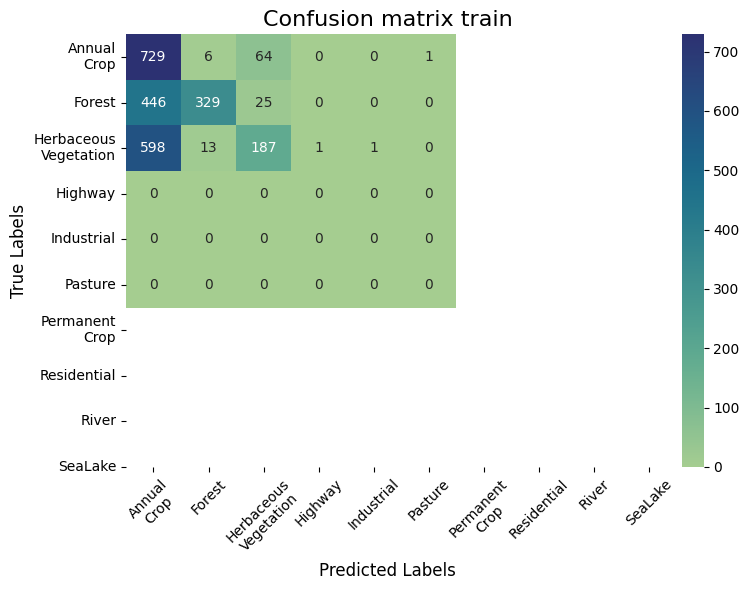

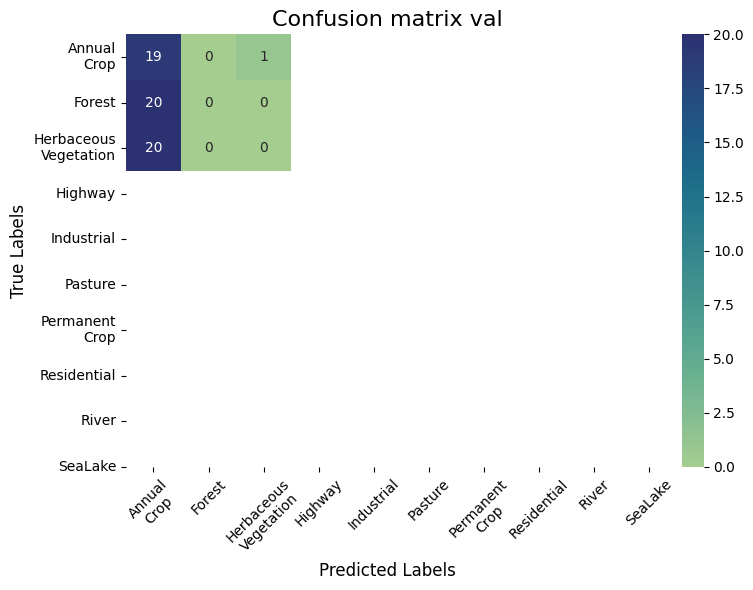

In [6]:
trainer.fit(model, train_loader, val_loader, 0.01)